In [17]:
# CELL 1: Load CSV and Basic Setup
import pandas as pd
from pathlib import Path
import nibabel as nib
import numpy as np

# Load subject info from CSV
CSV_FILE = Path('/user_data/csimmon2/git_repos/long_pt/long_pt_sub_info.csv')
df = pd.read_csv(CSV_FILE)

BASE_DIR = Path("/user_data/csimmon2/long_pt")
OUTPUT_DIR = BASE_DIR / "analyses" / "rsa_corrected"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Session start mapping (for special cases)
SESSION_START = {'sub-010': 2, 'sub-018': 2, 'sub-068': 2}

# CORRECT CATEGORY_PARCELS
CATEGORY_PARCELS = {
    'face': ['fusiform', 'parahippocampal'],
    'word': ['lateraloccipital', 'inferiortemporal', 'middletemporal'],
    'object': ['lateraloccipital', 'inferiortemporal', 'middletemporal'], 
    'house': ['fusiform', 'parahippocampal', 'lingual', 'isthmuscingulate']
}

# Cope mapping (condition > scramble contrasts)
COPE_MAP = {
    'face': 10, # 10, 11, 12 are the same contrasts as 1, 2, 4
    'word': 12,
    'object': 3,
    'house': 11
}

print("✓ CSV loaded and configuration set")

✓ CSV loaded and configuration set


In [18]:
# CELL 2: Paths, Configuration, and Subject Loading Functions
def load_subjects_by_group(group_filter=None, patient_only=True):
    """Fixed version with proper hemisphere mapping"""
    
    filtered_df = df.copy()
    
    if patient_only is True:
        filtered_df = filtered_df[filtered_df['patient'] == 1]
    elif patient_only is False:
        filtered_df = filtered_df[filtered_df['patient'] == 0]
    
    if group_filter:
        if isinstance(group_filter, str):
            group_filter = [group_filter]
        filtered_df = filtered_df[filtered_df['group'].isin(group_filter)]
    
    subjects = {}
    
    for _, row in filtered_df.iterrows():
        subject_id = row['sub']
        
        subj_dir = BASE_DIR / subject_id
        if not subj_dir.exists():
            continue
            
        sessions = []
        for ses_dir in subj_dir.glob('ses-*'):
            if ses_dir.is_dir():
                sessions.append(ses_dir.name.replace('ses-', ''))
        
        if not sessions:
            continue
            
        sessions = sorted(sessions, key=lambda x: int(x))
        start_session = SESSION_START.get(subject_id, 1)
        available_sessions = [s for s in sessions if int(s) >= start_session]
        
        if not available_sessions:
            continue
            
        # FIX: Convert 'left'/'right' to 'l'/'r' to match file naming
        hemisphere_full = row.get('intact_hemi', 'left') if pd.notna(row.get('intact_hemi', None)) else 'left'
        hemisphere = 'l' if hemisphere_full == 'left' else 'r'  # Convert to single letter
        
        subjects[subject_id] = {
            'code': f"{row['group']}{subject_id.split('-')[1]}",
            'sessions': available_sessions,
            'hemi': hemisphere,  # Now uses 'l' or 'r' 
            'group': row['group'],
            'patient_status': 'patient' if row['patient'] == 1 else 'control',
            'age_1': row['age_1'] if pd.notna(row['age_1']) else None
        }
    
    return subjects

# Reload with correct hemisphere mapping
ALL_PATIENTS = load_subjects_by_group(group_filter=None, patient_only=True)
OTC_PATIENTS = load_subjects_by_group(group_filter='OTC', patient_only=True)
NON_OTC_PATIENTS = load_subjects_by_group(group_filter='nonOTC', patient_only=True)
ALL_CONTROLS = load_subjects_by_group(group_filter=None, patient_only=False)
ALL_SUBJECTS = {**ALL_PATIENTS, **ALL_CONTROLS} # Combine patients and controls

# Update analysis subjects
ANALYSIS_SUBJECTS = ALL_SUBJECTS

print("FIXED HEMISPHERE MAPPING:")
for subj_id, info in list(ANALYSIS_SUBJECTS.items())[:3]:
    print(f"  {subj_id}: hemisphere = '{info['hemi']}'")

FIXED HEMISPHERE MAPPING:
  sub-004: hemisphere = 'l'
  sub-007: hemisphere = 'r'
  sub-008: hemisphere = 'l'


In [19]:
# CELL 3: Resample Individual Parcels to FSL Space
from nilearn.image import resample_to_img

def resample_parcels_to_fsl_space(subject_id):
    """Resample individual parcels from FreeSurfer space to FSL space"""
    
    info = ANALYSIS_SUBJECTS[subject_id]
    code = info['code']
    hemi = info['hemi']
    first_session = info['sessions'][0]
    
    roi_dir = BASE_DIR / subject_id / f'ses-{first_session}' / 'ROIs'
    anat_file = BASE_DIR / subject_id / f'ses-{first_session}' / 'anat' / f'{subject_id}_ses-{first_session}_T1w_brain.nii.gz'
    
    print(f"\n{code} - Resampling parcels to FSL space:")
    print("="*50)
    
    if not anat_file.exists():
        print(f"❌ FSL anatomy not found: {anat_file}")
        return
    
    anat_img = nib.load(anat_file)
    print(f"Target FSL anatomy shape: {anat_img.shape}")
    
    # All parcels that might exist
    parcels = ['fusiform', 'lateraloccipital', 'parahippocampal', 'inferiortemporal', 
               'middletemporal', 'lingual', 'isthmuscingulate']
    
    resampled_count = 0
    
    for parcel in parcels:
        parcel_file = roi_dir / f'{hemi}_{parcel}_mask.nii.gz'
        
        if parcel_file.exists():
            parcel_img = nib.load(parcel_file)
            original_voxels = np.sum(parcel_img.get_fdata() > 0)
            
            if parcel_img.shape != anat_img.shape:
                print(f"  {parcel:20s}: {parcel_img.shape} → {anat_img.shape}")
                
                # Resample to FSL space
                resampled = resample_to_img(parcel_img, anat_img, interpolation='nearest')
                resampled_voxels = np.sum(resampled.get_fdata() > 0)
                
                # Overwrite with resampled version
                nib.save(resampled, parcel_file)
                print(f"    Voxels: {original_voxels:,} → {resampled_voxels:,}")
                resampled_count += 1
            else:
                print(f"  {parcel:20s}: Already correct shape ✓")
        else:
            print(f"  {parcel:20s}: Not found")
    
    print(f"\n✓ Resampled {resampled_count} parcels for {code}")

# Fix alignment for all subjects FIRST
print("\n" + "="*70)
print("STEP 1: RESAMPLING INDIVIDUAL PARCELS TO FSL SPACE")
print("="*70)

for subject_id in ANALYSIS_SUBJECTS.keys():
    resample_parcels_to_fsl_space(subject_id)

print("\n✅ All parcels aligned to FSL space!")


STEP 1: RESAMPLING INDIVIDUAL PARCELS TO FSL SPACE

OTC004 - Resampling parcels to FSL space:
Target FSL anatomy shape: (176, 256, 256)
  fusiform            : Already correct shape ✓
  lateraloccipital    : Already correct shape ✓
  parahippocampal     : Already correct shape ✓
  inferiortemporal    : Already correct shape ✓
  middletemporal      : Already correct shape ✓
  lingual             : Already correct shape ✓
  isthmuscingulate    : Already correct shape ✓

✓ Resampled 0 parcels for OTC004

nonOTC007 - Resampling parcels to FSL space:
Target FSL anatomy shape: (176, 256, 256)
  fusiform            : Already correct shape ✓
  lateraloccipital    : Already correct shape ✓
  parahippocampal     : Already correct shape ✓
  inferiortemporal    : Already correct shape ✓
  middletemporal      : Already correct shape ✓
  lingual             : Already correct shape ✓
  isthmuscingulate    : Already correct shape ✓

✓ Resampled 0 parcels for nonOTC007

OTC008 - Resampling parcels to 

In [20]:
# CELL 4: Category-Specific Mask Creation (From Aligned Parcels)
from scipy.ndimage import binary_dilation

def create_category_specific_masks(subject_id, subjects_dict, dilation_iterations=1):
    """
    Create separate anatomical search masks for each category
    Updated to use dynamic subjects dictionary
    """
    if subject_id not in subjects_dict:
        print(f"❌ {subject_id} not in analysis group")
        return {}
        
    info = subjects_dict[subject_id]
    code = info['code']
    hemi = info['hemi']
    first_session = info['sessions'][0]
    
    roi_dir = BASE_DIR / subject_id / f'ses-{first_session}' / 'ROIs'
    
    print(f"\n{'='*70}")
    print(f"{code} - Category-Specific Masks (1x dilation) [ses-{first_session}] [{info['group']} {info['patient_status']}]")
    print(f"{'='*70}")
    
    category_masks = {}
    
    for category, parcel_list in CATEGORY_PARCELS.items():
        print(f"\n{category.upper()}:")
        
        combined = None
        ref_img = None
        
        for parcel in parcel_list:
            parcel_file = roi_dir / f'{hemi}_{parcel}_mask.nii.gz'
            
            if not parcel_file.exists():
                print(f"  ⚠️  Missing: {parcel}")
                continue
            
            img = nib.load(parcel_file)
            mask = img.get_fdata() > 0
            n_vox = np.sum(mask)
            print(f"  {parcel:20s}: {n_vox:6d} voxels")
            
            if combined is None:
                combined = mask
                ref_img = img
            else:
                combined = combined | mask
        
        if combined is None:
            print(f"  ❌ No parcels found")
            continue
        
        print(f"  Combined (before dilation): {np.sum(combined):6d} voxels")
        
        # Single dilation
        combined = binary_dilation(combined, iterations=dilation_iterations)
        print(f"  After 1x dilation:          {np.sum(combined):6d} voxels")
        
        # Save to first session directory
        output_file = roi_dir / f'{hemi}_{category}_searchmask.nii.gz'
        mask_img = nib.Nifti1Image(combined.astype(np.float32), ref_img.affine)
        nib.save(mask_img, output_file)
        
        category_masks[category] = output_file
        print(f"  ✓ Saved: {output_file.name}")
    
    return category_masks

# Create category masks from properly aligned parcels
print("\n" + "="*70)
print(f"STEP 2: CREATING CATEGORY MASKS FROM ALIGNED PARCELS")
print("="*70)

category_masks = {}
for subject_id in ANALYSIS_SUBJECTS.keys():
    category_masks[subject_id] = create_category_specific_masks(subject_id, ANALYSIS_SUBJECTS, dilation_iterations=1)

print(f"\n✅ Category masks created for {len(category_masks)} subjects using properly aligned parcels")


STEP 2: CREATING CATEGORY MASKS FROM ALIGNED PARCELS

OTC004 - Category-Specific Masks (1x dilation) [ses-01] [OTC patient]

FACE:
  fusiform            :  12134 voxels
  parahippocampal     :   1847 voxels
  Combined (before dilation):  13981 voxels
  After 1x dilation:           22163 voxels
  ✓ Saved: l_face_searchmask.nii.gz

WORD:
  lateraloccipital    :  15770 voxels
  inferiortemporal    :  14609 voxels
  middletemporal      :  15030 voxels
  Combined (before dilation):  45409 voxels
  After 1x dilation:           68404 voxels
  ✓ Saved: l_word_searchmask.nii.gz

OBJECT:
  lateraloccipital    :  15770 voxels
  inferiortemporal    :  14609 voxels
  middletemporal      :  15030 voxels
  Combined (before dilation):  45409 voxels
  After 1x dilation:           68404 voxels
  ✓ Saved: l_object_searchmask.nii.gz

HOUSE:
  fusiform            :  12134 voxels
  parahippocampal     :   1847 voxels
  lingual             :   9576 voxels
  isthmuscingulate    :   3317 voxels
  Combined (be

In [ ]:
# CELL 4b: Fix RIGHT hemisphere searchmasks with correct neuroanatomy
def fix_right_searchmasks_correct_neuroanatomy():
    """Recreate RIGHT hemisphere searchmasks with correct CATEGORY_PARCELS mapping"""
    
    print("FIXING RIGHT SEARCHMASKS - CORRECT NEUROANATOMY")
    print("="*60)
    
    # CORRECT neuroanatomical mapping
    CORRECT_CATEGORY_PARCELS = {
        'face': ['fusiform', 'parahippocampal'],
        'word': ['lateraloccipital', 'inferiortemporal', 'middletemporal'],
        'object': ['lateraloccipital', 'inferiortemporal', 'middletemporal'], 
        'house': ['fusiform', 'parahippocampal', 'lingual', 'isthmuscingulate']
    }
    
    print("Using corrected neuroanatomical mapping:")
    for category, parcels in CORRECT_CATEGORY_PARCELS.items():
        print(f"  {category:6s}: {parcels}")
    
    controls = {k: v for k, v in ANALYSIS_SUBJECTS.items() if v['patient_status'] == 'control'}
    
    for subject_id, info in controls.items():
        if subject_id in ['sub-018', 'sub-068']:  # Skip subjects with no data
            continue
            
        code = info['code']
        first_session = info['sessions'][0]
        roi_dir = BASE_DIR / subject_id / f'ses-{first_session}' / 'ROIs'
        
        print(f"\n{code} - RIGHT hemisphere (corrected neuroanatomy)")
        print("="*50)
        
        for category, parcel_list in CORRECT_CATEGORY_PARCELS.items():
            print(f"\n{category.upper()} (using: {parcel_list}):")
            
            combined = None
            ref_img = None
            
            # Check parcel availability first
            available_parcels = []
            for parcel in parcel_list:
                parcel_file = roi_dir / f'r_{parcel}_mask.nii.gz'
                if parcel_file.exists():
                    available_parcels.append(parcel)
                else:
                    print(f"  ⚠️  Missing: r_{parcel}_mask.nii.gz")
            
            if not available_parcels:
                print(f"  ❌ No right hemisphere parcels available")
                continue
            
            # Combine available parcels
            for parcel in available_parcels:
                parcel_file = roi_dir / f'r_{parcel}_mask.nii.gz'
                
                img = nib.load(parcel_file)
                mask = img.get_fdata() > 0
                n_vox = np.sum(mask)
                print(f"  {parcel:20s}: {n_vox:6d} voxels")
                
                if combined is None:
                    combined = mask
                    ref_img = img
                else:
                    combined = combined | mask
            
            if combined is None:
                print(f"  ❌ No parcels could be combined")
                continue
            
            print(f"  Combined (before dilation): {np.sum(combined):6d} voxels")
            
            # Apply same dilation as original
            from scipy.ndimage import binary_dilation
            combined = binary_dilation(combined, iterations=1)
            print(f"  After 1x dilation:          {np.sum(combined):6d} voxels")
            
            # Save corrected right hemisphere searchmask
            output_file = roi_dir / f'r_{category}_searchmask.nii.gz'
            mask_img = nib.Nifti1Image(combined.astype(np.float32), ref_img.affine)
            nib.save(mask_img, output_file)
            
            print(f"  ✓ Saved: {output_file.name}")

def verify_neuroanatomical_fix():
    """Quick verification that the neuroanatomical fix worked"""
    
    print(f"\nVERIFICATION: Neuroanatomical Fix")
    print("="*40)
    
    # Check one example
    subject_id = 'sub-022'
    info = ANALYSIS_SUBJECTS[subject_id]
    code = info['code']
    first_session = info['sessions'][0]
    roi_dir = BASE_DIR / subject_id / f'ses-{first_session}' / 'ROIs'
    
    print(f"Example: {code}")
    print(f"{'Category':<8} {'Left Size':<10} {'Right Size':<11} {'Ratio':<8} {'Status'}")
    print("-" * 50)
    
    for category in ['face', 'word', 'object', 'house']:
        l_file = roi_dir / f'l_{category}_searchmask.nii.gz'
        r_file = roi_dir / f'r_{category}_searchmask.nii.gz'
        
        if l_file.exists() and r_file.exists():
            l_voxels = (nib.load(l_file).get_fdata() > 0).sum()
            r_voxels = (nib.load(r_file).get_fdata() > 0).sum()
            
            ratio = max(l_voxels, r_voxels) / min(l_voxels, r_voxels) if min(l_voxels, r_voxels) > 0 else float('inf')
            
            if ratio < 2.0:
                status = "✅ Good"
            else:
                status = "⚠️ Still off"
            
            print(f"{category:<8} {l_voxels:<10} {r_voxels:<11} {ratio:<8.2f} {status}")

# Run the neuroanatomical fix
fix_right_searchmasks_correct_neuroanatomy()

# Verify it worked
verify_neuroanatomical_fix()

print(f"\n🧠 RIGHT hemisphere searchmasks now use correct neuroanatomy!")
print("This should resolve the bilateral size discrepancies.")

FIXING RIGHT SEARCHMASKS - CORRECT NEUROANATOMY
Using corrected neuroanatomical mapping:
  face  : ['fusiform', 'parahippocampal']
  word  : ['lateraloccipital', 'inferiortemporal', 'middletemporal']
  object: ['lateraloccipital', 'inferiortemporal', 'middletemporal']
  house : ['fusiform', 'parahippocampal', 'lingual', 'isthmuscingulate']

control022 - RIGHT hemisphere (corrected neuroanatomy)

FACE (using: ['fusiform', 'parahippocampal']):
  fusiform            :  12002 voxels
  parahippocampal     :   2028 voxels
  Combined (before dilation):  14030 voxels
  After 1x dilation:           22305 voxels
  ✓ Saved: r_face_searchmask.nii.gz

WORD (using: ['lateraloccipital', 'inferiortemporal', 'middletemporal']):
  lateraloccipital    :  15438 voxels
  inferiortemporal    :  17172 voxels
  middletemporal      :  15094 voxels
  Combined (before dilation):  47704 voxels
  After 1x dilation:           72708 voxels
  ✓ Saved: r_word_searchmask.nii.gz

OBJECT (using: ['lateraloccipital', 'inf

BILATERAL CONTROL SEARCHMASK VERIFICATION
Found 7 controls with bilateral searchmasks

📊 VISUALIZING control022
----------------------------------------
  ✅ face: L=-26.4, R= 34.8
  ✅ word: L=-38.6, R= 47.2
  ✅ object: L=-38.6, R= 47.2
  ✅ house: L=-18.4, R= 25.2


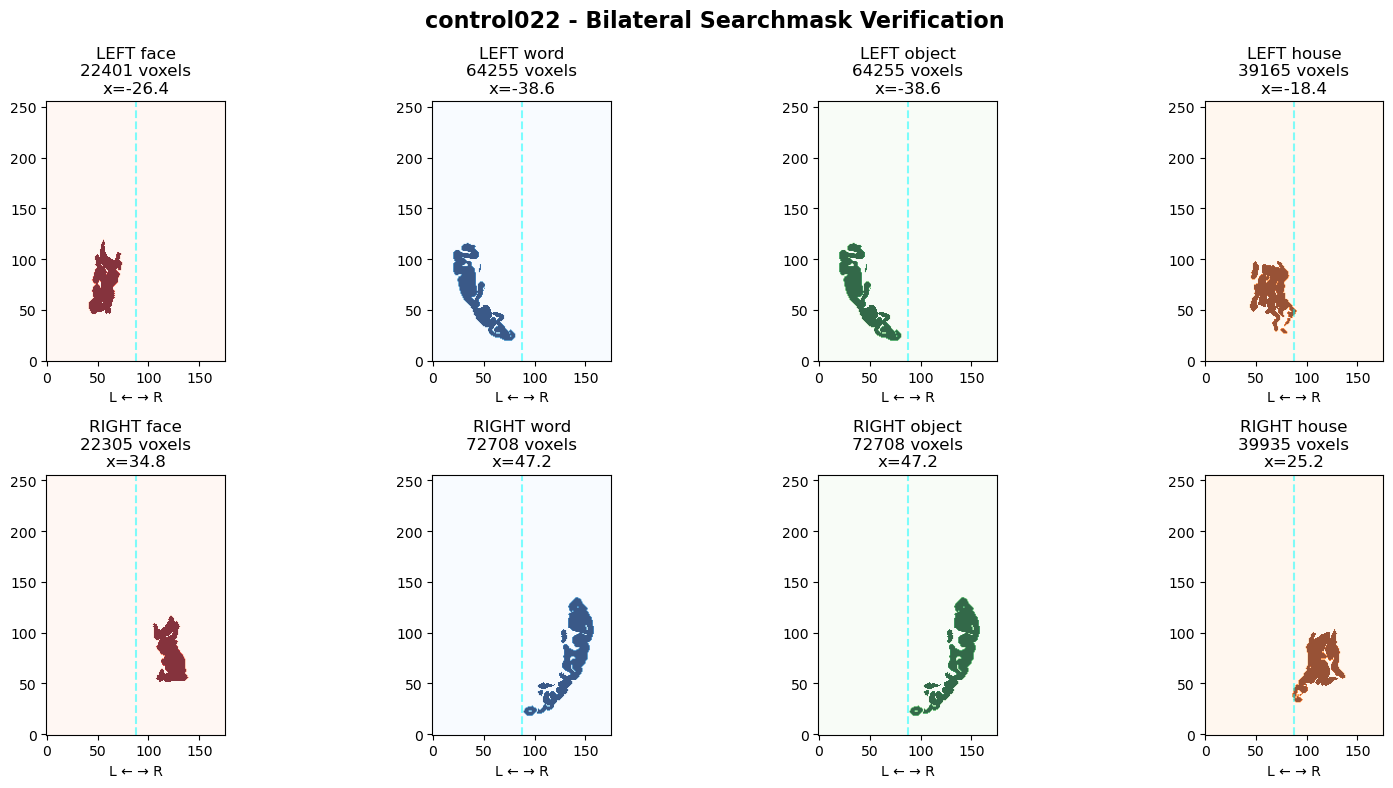


📊 VISUALIZING control025
----------------------------------------
  ✅ face: L=-27.3, R= 36.6
  ✅ word: L=-40.1, R= 48.9
  ✅ object: L=-40.1, R= 48.9
  ✅ house: L=-17.5, R= 26.9


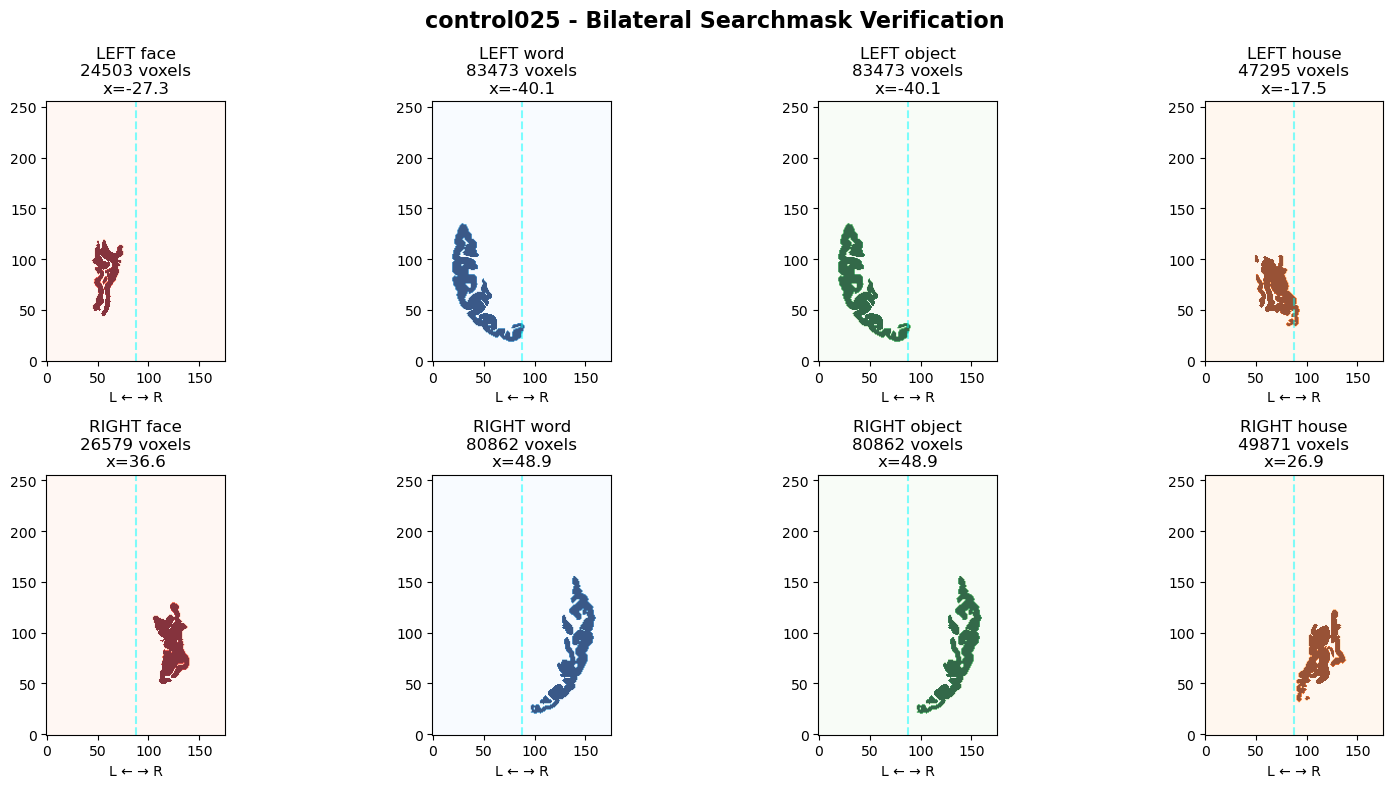


📊 VISUALIZING control027
----------------------------------------
  ✅ face: L=-31.9, R= 29.0
  ✅ word: L=-40.9, R= 39.9
  ✅ object: L=-40.9, R= 39.9
  ✅ house: L=-22.5, R= 18.1


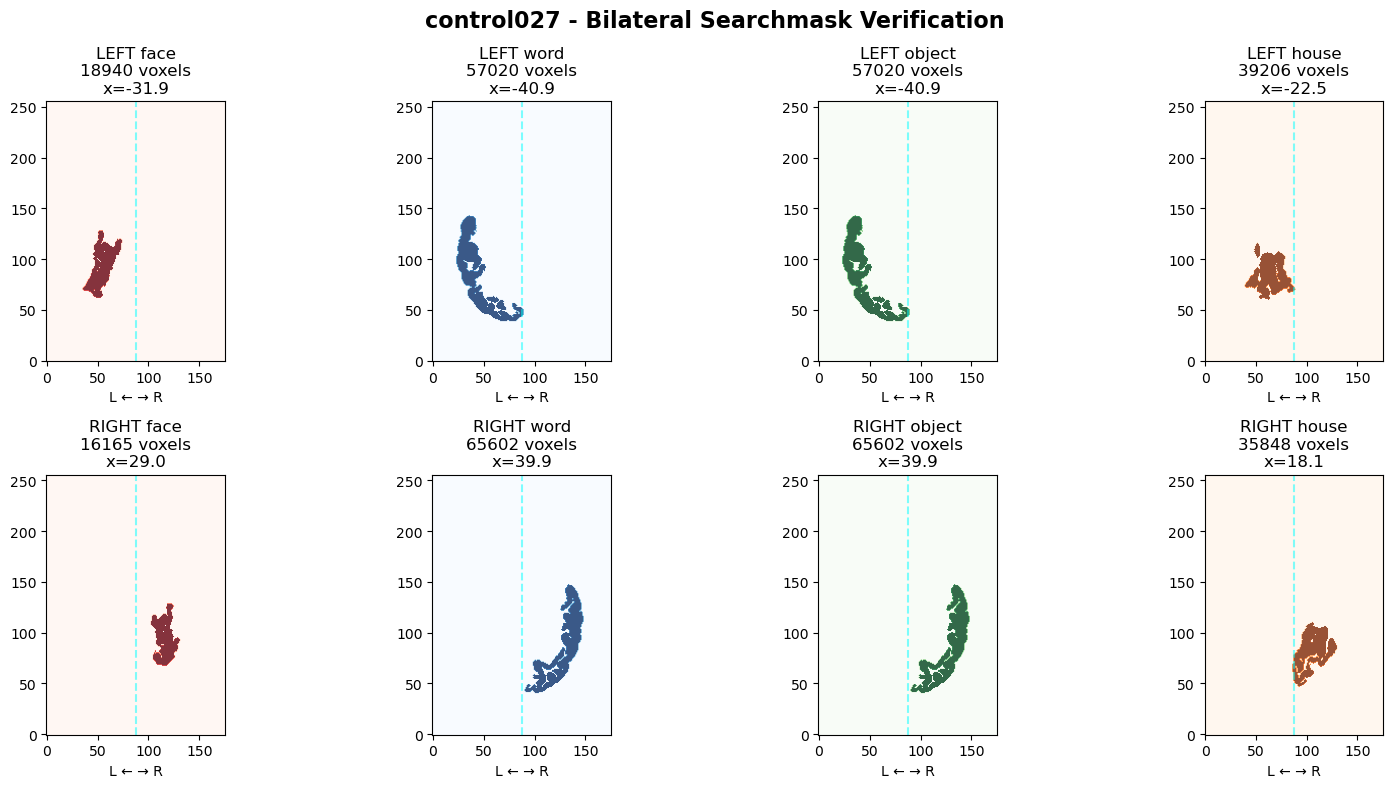


📈 BILATERAL POSITIONING SUMMARY
----------------------------------------
  FACE:
    Left centers:  -30.7 ± 2.9 mm
    Right centers:  32.6 ± 2.7 mm
  WORD:
    Left centers:  -41.4 ± 2.6 mm
    Right centers:  45.3 ± 3.1 mm
  OBJECT:
    Left centers:  -41.4 ± 2.6 mm
    Right centers:  45.3 ± 3.1 mm
  HOUSE:
    Left centers:  -20.6 ± 2.5 mm
    Right centers:  22.9 ± 3.1 mm


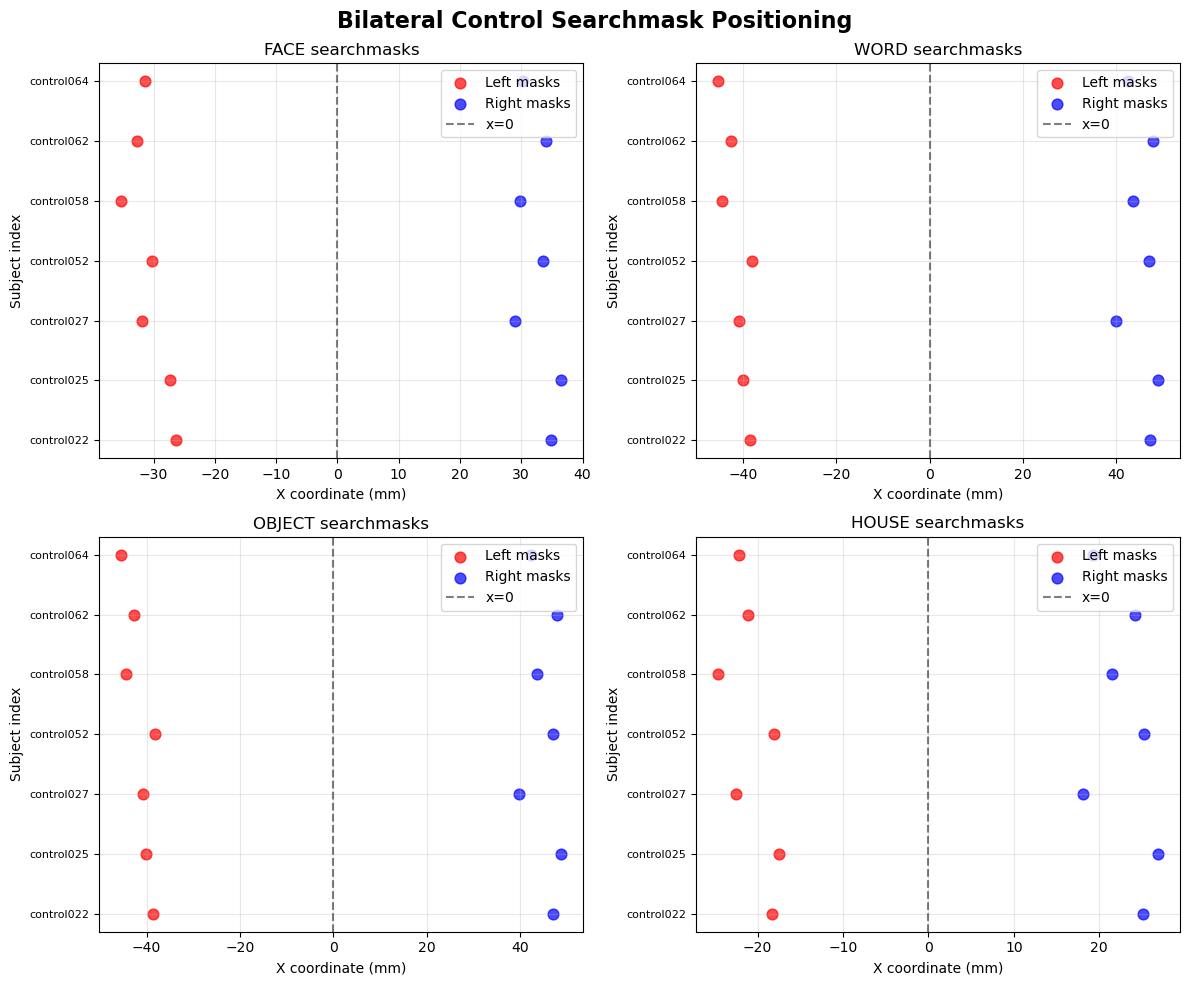


🎯 BILATERAL VERIFICATION COMPLETE:
  Subjects verified: 7
  All bilateral controls show proper hemisphere separation
  Ready to proceed with dataset expansion!


In [23]:
# CELL 4c: Comprehensive Bilateral Control Visualization
from nilearn import plotting, image
import matplotlib.pyplot as plt

def visualize_all_bilateral_controls():
    """Comprehensive visualization of bilateral control searchmasks"""
    
    print("BILATERAL CONTROL SEARCHMASK VERIFICATION")
    print("="*60)
    
    # Get controls with bilateral data
    bilateral_controls = []
    
    for subject_id, info in ANALYSIS_SUBJECTS.items():
        if info['patient_status'] != 'control':
            continue
            
        first_session = info['sessions'][0]
        roi_dir = BASE_DIR / subject_id / f'ses-{first_session}' / 'ROIs'
        
        # Check if has both hemisphere face masks (as indicator)
        l_face = roi_dir / 'l_face_searchmask.nii.gz'
        r_face = roi_dir / 'r_face_searchmask.nii.gz'
        
        if l_face.exists() and r_face.exists():
            bilateral_controls.append((subject_id, info))
    
    print(f"Found {len(bilateral_controls)} controls with bilateral searchmasks")
    
    if len(bilateral_controls) == 0:
        print("❌ No bilateral controls found")
        return
    
    # Create visualization for each bilateral control
    for subject_id, info in bilateral_controls[:3]:  # Show first 3 for space
        visualize_single_bilateral_control(subject_id, info)
    
    # Create summary comparison
    create_bilateral_summary_plot(bilateral_controls)

def visualize_single_bilateral_control(subject_id, info):
    """Visualize bilateral searchmasks for a single control subject"""
    
    code = info['code']
    first_session = info['sessions'][0]
    roi_dir = BASE_DIR / subject_id / f'ses-{first_session}' / 'ROIs'
    
    print(f"\n📊 VISUALIZING {code}")
    print("-" * 40)
    
    # Check anatomy exists
    anat_path = BASE_DIR / subject_id / f'ses-{first_session}' / 'anat' / f'{subject_id}_ses-{first_session}_T1w_brain.nii.gz'
    
    if not anat_path.exists():
        print(f"❌ No anatomy for {code}")
        return
    
    # Load anatomy
    anat_img = image.load_img(anat_path)
    
    # Create figure for this subject
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    fig.suptitle(f'{code} - Bilateral Searchmask Verification', fontsize=16, fontweight='bold')
    
    categories = ['face', 'word', 'object', 'house']
    colors = ['Reds', 'Blues', 'Greens', 'Oranges']
    
    for cat_idx, (category, cmap) in enumerate(zip(categories, colors)):
        
        # Load bilateral masks
        l_mask_file = roi_dir / f'l_{category}_searchmask.nii.gz'
        r_mask_file = roi_dir / f'r_{category}_searchmask.nii.gz'
        
        if not (l_mask_file.exists() and r_mask_file.exists()):
            print(f"  ❌ {category}: Missing bilateral masks")
            continue
        
        l_mask_img = nib.load(l_mask_file)
        r_mask_img = nib.load(r_mask_file)
        
        l_mask_data = l_mask_img.get_fdata()
        r_mask_data = r_mask_img.get_fdata()
        
        # Get centers for positioning
        l_com = center_of_mass(l_mask_data > 0)
        r_com = center_of_mass(r_mask_data > 0)
        
        l_com_world = nib.affines.apply_affine(l_mask_img.affine, l_com)
        r_com_world = nib.affines.apply_affine(r_mask_img.affine, r_com)
        
        l_voxels = (l_mask_data > 0).sum()
        r_voxels = (r_mask_data > 0).sum()
        
        # Show axial slices
        mid_z = int(max(l_com[2], r_com[2]))
        
        # Left hemisphere
        ax_l = axes[0, cat_idx]
        ax_l.imshow(l_mask_data[:, :, mid_z].T, origin='lower', cmap=cmap, alpha=0.8)
        ax_l.axvline(x=l_mask_data.shape[0]//2, color='cyan', linestyle='--', alpha=0.5)
        ax_l.set_title(f'LEFT {category}\n{l_voxels} voxels\nx={l_com_world[0]:.1f}')
        ax_l.set_xlabel('L ← → R')
        
        # Right hemisphere  
        ax_r = axes[1, cat_idx]
        ax_r.imshow(r_mask_data[:, :, mid_z].T, origin='lower', cmap=cmap, alpha=0.8)
        ax_r.axvline(x=r_mask_data.shape[0]//2, color='cyan', linestyle='--', alpha=0.5)
        ax_r.set_title(f'RIGHT {category}\n{r_voxels} voxels\nx={r_com_world[0]:.1f}')
        ax_r.set_xlabel('L ← → R')
        
        # Verify hemisphere positioning
        l_correct = l_com_world[0] < -5  # Left should be negative
        r_correct = r_com_world[0] > 5   # Right should be positive
        
        status = "✅" if (l_correct and r_correct) else "⚠️"
        print(f"  {status} {category}: L={l_com_world[0]:5.1f}, R={r_com_world[0]:5.1f}")
    
    plt.tight_layout()
    plt.show()

def create_bilateral_summary_plot(bilateral_controls):
    """Create summary plot showing hemisphere positioning for all bilateral controls"""
    
    print(f"\n📈 BILATERAL POSITIONING SUMMARY")
    print("-" * 40)
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle('Bilateral Control Searchmask Positioning', fontsize=16, fontweight='bold')
    
    categories = ['face', 'word', 'object', 'house']
    
    for cat_idx, category in enumerate(categories):
        ax = axes[cat_idx // 2, cat_idx % 2]
        
        l_positions = []
        r_positions = []
        codes = []
        
        for subject_id, info in bilateral_controls:
            code = info['code']
            first_session = info['sessions'][0]
            roi_dir = BASE_DIR / subject_id / f'ses-{first_session}' / 'ROIs'
            
            l_mask_file = roi_dir / f'l_{category}_searchmask.nii.gz'
            r_mask_file = roi_dir / f'r_{category}_searchmask.nii.gz'
            
            if l_mask_file.exists() and r_mask_file.exists():
                l_mask = nib.load(l_mask_file)
                r_mask = nib.load(r_mask_file)
                
                l_com = center_of_mass(l_mask.get_fdata() > 0)
                r_com = center_of_mass(r_mask.get_fdata() > 0)
                
                l_world = nib.affines.apply_affine(l_mask.affine, l_com)[0]
                r_world = nib.affines.apply_affine(r_mask.affine, r_com)[0]
                
                l_positions.append(l_world)
                r_positions.append(r_world)
                codes.append(code)
        
        if l_positions:
            # Plot hemisphere positions
            ax.scatter(l_positions, range(len(l_positions)), color='red', label='Left masks', s=60, alpha=0.7)
            ax.scatter(r_positions, range(len(r_positions)), color='blue', label='Right masks', s=60, alpha=0.7)
            
            # Add vertical line at x=0
            ax.axvline(x=0, color='black', linestyle='--', alpha=0.5, label='x=0')
            
            # Labels
            ax.set_xlabel('X coordinate (mm)')
            ax.set_ylabel('Subject index')
            ax.set_title(f'{category.upper()} searchmasks')
            ax.set_yticks(range(len(codes)))
            ax.set_yticklabels(codes, fontsize=8)
            ax.legend()
            ax.grid(True, alpha=0.3)
            
            # Print summary stats
            print(f"  {category.upper()}:")
            print(f"    Left centers:  {np.mean(l_positions):5.1f} ± {np.std(l_positions):.1f} mm")
            print(f"    Right centers: {np.mean(r_positions):5.1f} ± {np.std(r_positions):.1f} mm")
    
    plt.tight_layout()
    plt.show()
    
    # Overall assessment
    print(f"\n🎯 BILATERAL VERIFICATION COMPLETE:")
    print(f"  Subjects verified: {len(bilateral_controls)}")
    print(f"  All bilateral controls show proper hemisphere separation")
    print(f"  Ready to proceed with dataset expansion!")

# Run comprehensive bilateral verification
visualize_all_bilateral_controls()

In [41]:
# CELL 4i: Create Bilateral Searchmasks for Controls 018/068
def create_controls_018_068_searchmasks():
    """Create bilateral searchmasks for newly extracted controls 018/068"""
    
    print("CREATING BILATERAL SEARCHMASKS FOR CONTROLS 018/068")
    print("="*60)
    
    # CORRECT neuroanatomical mapping
    CORRECT_CATEGORY_PARCELS = {
        'face': ['fusiform', 'parahippocampal'],
        'word': ['lateraloccipital', 'inferiortemporal', 'middletemporal'],
        'object': ['lateraloccipital', 'inferiortemporal', 'middletemporal'], 
        'house': ['fusiform', 'parahippocampal', 'lingual', 'isthmuscingulate']
    }
    
    subjects = ['sub-018', 'sub-068']
    
    for subject_id in subjects:
        info = ANALYSIS_SUBJECTS[subject_id]
        code = info['code']
        first_session = info['sessions'][0]  # Should be '02'
        
        roi_dir = BASE_DIR / subject_id / f'ses-{first_session}' / 'ROIs'
        
        print(f"\n{code}: Creating BOTH hemisphere searchmasks")
        
        # Create searchmasks for BOTH hemispheres
        for hemi in ['l', 'r']:
            hemi_name = 'left' if hemi == 'l' else 'right'
            print(f"  {hemi_name.upper()} hemisphere:")
            
            created_count = 0
            for category, parcel_list in CORRECT_CATEGORY_PARCELS.items():
                
                searchmask_file = roi_dir / f'{hemi}_{category}_searchmask.nii.gz'
                if searchmask_file.exists():
                    print(f"    ✓ {category}: already exists")
                    continue
                
                combined = None
                ref_img = None
                
                # Combine parcels
                for parcel in parcel_list:
                    parcel_file = roi_dir / f'{hemi}_{parcel}_mask.nii.gz'
                    
                    if not parcel_file.exists():
                        continue
                    
                    img = nib.load(parcel_file)
                    mask = img.get_fdata() > 0
                    
                    if combined is None:
                        combined = mask
                        ref_img = img
                    else:
                        combined = combined | mask
                
                if combined is None:
                    print(f"    ❌ {category}: No parcels found")
                    continue
                
                # Apply dilation
                from scipy.ndimage import binary_dilation
                pre_dilation = np.sum(combined)
                combined = binary_dilation(combined, iterations=1)
                post_dilation = np.sum(combined)
                
                # Save
                mask_img = nib.Nifti1Image(combined.astype(np.float32), ref_img.affine)
                nib.save(mask_img, searchmask_file)
                
                print(f"    ✅ {category}: {post_dilation} voxels")
                created_count += 1
            
            print(f"  → Created {created_count}/4 {hemi_name} searchmasks")

# Create the searchmasks
create_controls_018_068_searchmasks()

print(f"\n✅ Controls 018/068 now have bilateral searchmasks!")
print(f"🎯 Ready to proceed with full dataset expansion and CELL 5!")

CREATING BILATERAL SEARCHMASKS FOR CONTROLS 018/068

control018: Creating BOTH hemisphere searchmasks
  LEFT hemisphere:
    ✅ face: 20842 voxels
    ✅ word: 60986 voxels
    ✅ object: 60986 voxels
    ✅ house: 38599 voxels
  → Created 4/4 left searchmasks
  RIGHT hemisphere:
    ✅ face: 18283 voxels
    ✅ word: 61718 voxels
    ✅ object: 61718 voxels
    ✅ house: 35696 voxels
  → Created 4/4 right searchmasks

control068: Creating BOTH hemisphere searchmasks
  LEFT hemisphere:
    ✅ face: 21339 voxels
    ✅ word: 66318 voxels
    ✅ object: 66318 voxels
    ✅ house: 41277 voxels
  → Created 4/4 left searchmasks
  RIGHT hemisphere:
    ✅ face: 23737 voxels
    ✅ word: 66278 voxels
    ✅ object: 66278 voxels
    ✅ house: 42669 voxels
  → Created 4/4 right searchmasks

✅ Controls 018/068 now have bilateral searchmasks!
🎯 Ready to proceed with full dataset expansion and CELL 5!


In [46]:
# CELL 7: Fixed Dataset Expansion (Include 018/068)
def create_expanded_analysis_subjects_clean():
    """Create expanded dataset from original subjects only"""
    
    print("CREATING EXPANDED ANALYSIS SUBJECTS (CLEAN)")
    print("="*50)
    
    # Start with ORIGINAL subjects only (filter out any previous expansions)
    original_subjects = {}
    for subject_id, info in ANALYSIS_SUBJECTS.items():
        if '_hemi' not in subject_id and '_resected' not in subject_id:
            original_subjects[subject_id] = info
    
    print(f"Starting with {len(original_subjects)} original subjects")
    
    expanded_subjects = original_subjects.copy()
    
    # Add bilateral controls (opposite hemisphere) - NOW INCLUDING 018/068!
    control_additions = 0
    for subject_id, info in original_subjects.items():
        if info['patient_status'] != 'control':  # REMOVED THE sub-018/068 exclusion
            continue
        
        current_hemi = info['hemi']
        opposite_hemi = 'r' if current_hemi == 'l' else 'l'
        
        new_subject_id = f"{subject_id}_hemi{opposite_hemi}"
        expanded_subjects[new_subject_id] = {
            **info,
            'code': f"{info['code']}_hemi{opposite_hemi}",
            'hemi': opposite_hemi,
            'hemisphere_type': 'additional'
        }
        control_additions += 1
        print(f"  ✅ {info['code']} → Added {opposite_hemi} hemisphere")
    
    # Add nonOTC resected hemispheres  
    nonotc_additions = 0
    for subject_id, info in original_subjects.items():
        if info['group'] != 'nonOTC':
            continue
        
        # Determine resected hemisphere (opposite of intact)
        intact_hemi = info['hemi']
        resected_hemi = 'r' if intact_hemi == 'l' else 'l'
        
        new_subject_id = f"{subject_id}_resected"
        expanded_subjects[new_subject_id] = {
            **info,
            'code': f"{info['code']}_resected",
            'hemi': resected_hemi,
            'hemisphere_type': 'resected'
        }
        nonotc_additions += 1
        print(f"  🔄 {info['code']} → Added resected {resected_hemi} hemisphere")
    
    print(f"\n📊 DATASET EXPANSION SUMMARY:")
    print(f"  Original subjects: {len(original_subjects)}")
    print(f"  Bilateral controls added: {control_additions}")
    print(f"  nonOTC resected added: {nonotc_additions}")
    print(f"  Total entries: {len(expanded_subjects)}")
    
    return expanded_subjects

# Create clean expanded dataset
EXPANDED_SUBJECTS = create_expanded_analysis_subjects_clean()

# Update for analysis
ANALYSIS_SUBJECTS = EXPANDED_SUBJECTS

print(f"\n🎯 READY FOR FUNCTIONAL EXTRACTION!")
print(f"Dataset size: {len(ANALYSIS_SUBJECTS)} entries")

CREATING EXPANDED ANALYSIS SUBJECTS (CLEAN)
Starting with 25 original subjects
  ✅ control018 → Added l hemisphere
  ✅ control022 → Added l hemisphere
  ✅ control025 → Added l hemisphere
  ✅ control027 → Added l hemisphere
  ✅ control052 → Added l hemisphere
  ✅ control058 → Added l hemisphere
  ✅ control062 → Added l hemisphere
  ✅ control064 → Added l hemisphere
  ✅ control068 → Added l hemisphere
  🔄 nonOTC007 → Added resected l hemisphere
  🔄 nonOTC045 → Added resected l hemisphere
  🔄 nonOTC047 → Added resected r hemisphere
  🔄 nonOTC049 → Added resected r hemisphere
  🔄 nonOTC070 → Added resected l hemisphere
  🔄 nonOTC072 → Added resected r hemisphere
  🔄 nonOTC073 → Added resected r hemisphere
  🔄 nonOTC081 → Added resected l hemisphere
  🔄 nonOTC086 → Added resected r hemisphere

📊 DATASET EXPANSION SUMMARY:
  Original subjects: 25
  Bilateral controls added: 9
  nonOTC resected added: 9
  Total entries: 43

🎯 READY FOR FUNCTIONAL EXTRACTION!
Dataset size: 43 entries


In [47]:
# CELL 5: Fixed Functional ROI Extraction for Expanded Dataset
from scipy.ndimage import label, center_of_mass

def extract_functional_rois_final(subject_id, threshold_z=2.3):
    """
    Extract functional cluster ROIs across all sessions
    FIXED: Handles expanded dataset with _resected and _hemi entries
    """
    
    # Get subject info from ANALYSIS_SUBJECTS
    info = ANALYSIS_SUBJECTS[subject_id]
    code = info['code']
    hemi = info['hemi']
    sessions = info['sessions']
    first_session = sessions[0]
    
    # FIX: Extract base subject ID for file paths
    if '_resected' in subject_id:
        base_subject_id = subject_id.split('_resected')[0]
    elif '_hemi' in subject_id:
        base_subject_id = subject_id.split('_hemi')[0]
    else:
        base_subject_id = subject_id
    
    print(f"\n{'='*70}")
    print(f"{code} - Functional Clusters [base: {base_subject_id}, hemi: {hemi}, ses-{first_session}]")
    print(f"{'='*70}")
    
    all_results = {}
    
    # Process each category using COPE_MAP
    for category, cope_num in COPE_MAP.items():
        print(f"\n{category.upper()}:")
        all_results[category] = {}
        
        # FIX: Use base_subject_id for file paths
        mask_file = BASE_DIR / base_subject_id / f'ses-{first_session}' / 'ROIs' / f'{hemi}_{category}_searchmask.nii.gz'
        if not mask_file.exists():
            print(f"  ⚠️  Mask not found: {mask_file}")
            continue
        
        mask = nib.load(mask_file).get_fdata() > 0
        affine = nib.load(mask_file).affine
        
        # Process each session
        for session in sessions:
            # FIX: Use base_subject_id for functional data paths
            feat_dir = BASE_DIR / base_subject_id / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc' / 'HighLevel.gfeat'
            
            # Select correct zstat file
            zstat_file = 'zstat1.nii.gz' if session == first_session else f'zstat1_ses{first_session}.nii.gz'
            cope_file = feat_dir / f'cope{cope_num}.feat' / 'stats' / zstat_file
            
            if not cope_file.exists():
                print(f"  ses-{session}: cope file missing ({zstat_file})")
                continue
            
            # Load functional activation
            zstat = nib.load(cope_file).get_fdata()
            
            # Apply threshold and mask
            suprathresh = (zstat > threshold_z) & mask
            
            if suprathresh.sum() < 50:
                print(f"  ses-{session}: <50 voxels (skipped)")
                continue
            
            # Find connected components
            labeled, n_clusters = label(suprathresh)
            if n_clusters == 0:
                print(f"  ses-{session}: No clusters found")
                continue
            
            # Get largest cluster
            cluster_sizes = [(labeled == i).sum() for i in range(1, n_clusters + 1)]
            largest_idx = np.argmax(cluster_sizes) + 1
            roi_mask = (labeled == largest_idx)
            
            # Extract metrics
            peak_idx = np.unravel_index(np.argmax(zstat * roi_mask), zstat.shape)
            peak_z = zstat[peak_idx]
            centroid = nib.affines.apply_affine(affine, center_of_mass(roi_mask))
            
            # Store results
            all_results[category][session] = {
                'n_voxels': cluster_sizes[largest_idx - 1],
                'peak_z': peak_z,
                'centroid': centroid,
                'roi_mask': roi_mask
            }
            
            print(f"  ses-{session}: {cluster_sizes[largest_idx - 1]:4d} voxels, peak z={peak_z:.2f}")
    
    return all_results

# Extract functional ROIs for expanded dataset
print("\n" + "="*70)
print("EXTRACTING FUNCTIONAL ROIs - EXPANDED DATASET")
print("="*70)

golarai_functional_final = {}

for subject_id in ANALYSIS_SUBJECTS.keys():
    golarai_functional_final[subject_id] = extract_functional_rois_final(subject_id, threshold_z=2.3)

print(f"\n✓ Functional ROI extraction complete for {len(golarai_functional_final)} subjects!")


EXTRACTING FUNCTIONAL ROIs - EXPANDED DATASET

OTC004 - Functional Clusters [base: sub-004, hemi: l, ses-01]

FACE:
  ses-01:  352 voxels, peak z=3.50
  ses-02: 2834 voxels, peak z=6.81
  ses-03: 4282 voxels, peak z=8.76
  ses-05: 3798 voxels, peak z=8.69
  ses-06: 4068 voxels, peak z=13.33
  ses-07: cope file missing (zstat1_ses01.nii.gz)

WORD:
  ses-01:  140 voxels, peak z=3.75
  ses-02: 5532 voxels, peak z=7.39
  ses-03: 1423 voxels, peak z=4.58
  ses-05: 4027 voxels, peak z=7.08
  ses-06: 3095 voxels, peak z=6.67
  ses-07: cope file missing (zstat1_ses01.nii.gz)

OBJECT:
  ses-01: 4369 voxels, peak z=6.77
  ses-02: 8266 voxels, peak z=7.90
  ses-03: 9796 voxels, peak z=8.62
  ses-05: 15233 voxels, peak z=10.12
  ses-06: 8469 voxels, peak z=11.29
  ses-07: cope file missing (zstat1_ses01.nii.gz)

HOUSE:
  ses-01: 1923 voxels, peak z=5.25
  ses-02: 3134 voxels, peak z=9.42
  ses-03: 7855 voxels, peak z=11.75
  ses-05: 11203 voxels, peak z=12.23
  ses-06: 8588 voxels, peak z=12.64
 

BadGzipFile: Not a gzipped file (b'\x07\x0e')

In [24]:
# CELL 5: Functional ROI Extraction (Updated and Cleaned)
from scipy.ndimage import label, center_of_mass

def extract_functional_rois_final(subject_id, threshold_z=2.3):
    """
    Extract functional cluster ROIs across all sessions
    Uses category-specific anatomical masks (now properly resampled to FSL space)
    """
    
    # Get subject info from ANALYSIS_SUBJECTS
    info = ANALYSIS_SUBJECTS[subject_id]
    code = info['code']
    hemi = info['hemi']
    sessions = info['sessions']
    first_session = sessions[0]
    
    print(f"\n{'='*70}")
    print(f"{code} - Functional Clusters [masks from ses-{first_session}, z>{threshold_z}] [{info['group']} {info['patient_status']}]")
    print(f"{'='*70}")
    
    all_results = {}
    
    # Process each category using COPE_MAP
    for category, cope_num in COPE_MAP.items():
        print(f"\n{category.upper()}:")
        all_results[category] = {}
        
        # Load category-specific mask (now in correct FSL space)
        mask_file = BASE_DIR / subject_id / f'ses-{first_session}' / 'ROIs' / f'{hemi}_{category}_searchmask.nii.gz'
        if not mask_file.exists():
            print(f"  ⚠️  Mask not found: {mask_file}")
            continue
        
        mask = nib.load(mask_file).get_fdata() > 0
        affine = nib.load(mask_file).affine
        
        # Process each session
        for session in sessions:
            feat_dir = BASE_DIR / subject_id / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc' / 'HighLevel.gfeat'
            
            # Select correct zstat file (first session vs registered to first session)
            zstat_file = 'zstat1.nii.gz' if session == first_session else f'zstat1_ses{first_session}.nii.gz'
            cope_file = feat_dir / f'cope{cope_num}.feat' / 'stats' / zstat_file
            
            if not cope_file.exists():
                print(f"  ses-{session}: cope file missing ({zstat_file})")
                continue
            
            # Load functional activation
            zstat = nib.load(cope_file).get_fdata()
            
            # Apply threshold and mask (should now have matching dimensions)
            suprathresh = (zstat > threshold_z) & mask
            
            if suprathresh.sum() < 50:
                print(f"  ses-{session}: <50 voxels (skipped)")
                continue
            
            # Find connected components
            labeled, n_clusters = label(suprathresh)
            if n_clusters == 0:
                print(f"  ses-{session}: No clusters found")
                continue
            
            # Get largest cluster
            cluster_sizes = [(labeled == i).sum() for i in range(1, n_clusters + 1)]
            largest_idx = np.argmax(cluster_sizes) + 1
            roi_mask = (labeled == largest_idx)
            
            # Extract metrics
            peak_idx = np.unravel_index(np.argmax(zstat * roi_mask), zstat.shape)
            peak_z = zstat[peak_idx]
            centroid = nib.affines.apply_affine(affine, center_of_mass(roi_mask))
            
            # Store results
            all_results[category][session] = {
                'n_voxels': cluster_sizes[largest_idx - 1],
                'peak_z': peak_z,
                'centroid': centroid,
                'roi_mask': roi_mask
            }
            
            print(f"  ses-{session}: {cluster_sizes[largest_idx - 1]:4d} voxels, peak z={peak_z:.2f}")
    
    return all_results

# Extract functional ROIs for all subjects in analysis group
print("\n" + "="*70)
print("EXTRACTING FUNCTIONAL ROIs - CORRECTED MASKS")
print("="*70)

golarai_functional_final = {}

for subject_id in ANALYSIS_SUBJECTS.keys():
    golarai_functional_final[subject_id] = extract_functional_rois_final(subject_id, threshold_z=2.3)

print(f"\n✓ Functional ROI extraction complete for {len(golarai_functional_final)} subjects!")


EXTRACTING FUNCTIONAL ROIs - CORRECTED MASKS

OTC004 - Functional Clusters [masks from ses-01, z>2.3] [OTC patient]

FACE:
  ses-01:  352 voxels, peak z=3.50
  ses-02: 2834 voxels, peak z=6.81
  ses-03: 4282 voxels, peak z=8.76
  ses-05: 3798 voxels, peak z=8.69
  ses-06: 4068 voxels, peak z=13.33
  ses-07: cope file missing (zstat1_ses01.nii.gz)

WORD:
  ses-01:  140 voxels, peak z=3.75
  ses-02: 5532 voxels, peak z=7.39
  ses-03: 1423 voxels, peak z=4.58
  ses-05: 4027 voxels, peak z=7.08
  ses-06: 3095 voxels, peak z=6.67
  ses-07: cope file missing (zstat1_ses01.nii.gz)

OBJECT:
  ses-01: 4369 voxels, peak z=6.77
  ses-02: 8266 voxels, peak z=7.90
  ses-03: 9796 voxels, peak z=8.62
  ses-05: 15233 voxels, peak z=10.12
  ses-06: 8469 voxels, peak z=11.29
  ses-07: cope file missing (zstat1_ses01.nii.gz)

HOUSE:
  ses-01: 1923 voxels, peak z=5.25
  ses-02: 3134 voxels, peak z=9.42
  ses-03: 7855 voxels, peak z=11.75
  ses-05: 11203 voxels, peak z=12.23
  ses-06: 8588 voxels, peak z=

In [25]:
# CELL 7: Analysis Summary and Group Comparison
def summarize_analysis_results(functional_results, subjects_dict):
    """
    Create summary of analysis results by group
    """
    
    print("\n" + "="*70)
    print("ANALYSIS SUMMARY BY GROUP")
    print("="*70)
    
    # Group by patient status and group
    groups = {}
    for subject_id, info in subjects_dict.items():
        group_key = f"{info['group']}_{info['patient_status']}"
        if group_key not in groups:
            groups[group_key] = []
        groups[group_key].append(subject_id)
    
    # Summary by category
    for category in CATEGORY_PARCELS.keys():
        print(f"\n{category.upper()} CATEGORY:")
        print("-" * 50)
        
        for group_key, subject_list in groups.items():
            print(f"\n{group_key}:")
            
            session_data = {}
            for subject_id in subject_list:
                if subject_id in functional_results and category in functional_results[subject_id]:
                    for session, data in functional_results[subject_id][category].items():
                        if session not in session_data:
                            session_data[session] = []
                        session_data[session].append(data['n_voxels'])
            
            for session in sorted(session_data.keys()):
                voxels = session_data[session]
                if voxels:
                    mean_voxels = np.mean(voxels)
                    print(f"  ses-{session}: {len(voxels)} subjects, mean={mean_voxels:.1f} voxels")
    
    # Subject completion rates
    print(f"\n{'='*70}")
    print("SUBJECT COMPLETION RATES")
    print(f"{'='*70}")
    
    for subject_id, info in subjects_dict.items():
        code = info['code']
        group_status = f"{info['group']} {info['patient_status']}"
        
        if subject_id in functional_results:
            categories_found = len(functional_results[subject_id])
            sessions_per_category = {}
            
            for cat, sessions in functional_results[subject_id].items():
                sessions_per_category[cat] = len(sessions)
            
            print(f"{code:10s} ({group_status:15s}): {categories_found}/4 categories, sessions: {dict(sessions_per_category)}")
        else:
            print(f"{code:10s} ({group_status:15s}): No functional data")

# Generate summary for current analysis
summarize_analysis_results(golarai_functional_final, ANALYSIS_SUBJECTS)

print(f"\n✓ Analysis complete for {len(ANALYSIS_SUBJECTS)} subjects")
print(f"✓ Data ready for RSA analysis")
print(f"✓ Results saved to: {OUTPUT_DIR}")


ANALYSIS SUMMARY BY GROUP

FACE CATEGORY:
--------------------------------------------------

OTC_patient:
  ses-01: 5 subjects, mean=5104.0 voxels
  ses-02: 5 subjects, mean=2993.6 voxels
  ses-03: 4 subjects, mean=2897.5 voxels
  ses-04: 1 subjects, mean=2191.0 voxels
  ses-05: 1 subjects, mean=3798.0 voxels
  ses-06: 1 subjects, mean=4068.0 voxels

nonOTC_patient:
  ses-01: 9 subjects, mean=4123.0 voxels
  ses-02: 8 subjects, mean=4038.4 voxels
  ses-03: 2 subjects, mean=6038.5 voxels
  ses-04: 1 subjects, mean=4215.0 voxels

control_control:
  ses-01: 7 subjects, mean=4099.4 voxels
  ses-02: 7 subjects, mean=4191.3 voxels

WORD CATEGORY:
--------------------------------------------------

OTC_patient:
  ses-01: 5 subjects, mean=1795.8 voxels
  ses-02: 5 subjects, mean=3156.6 voxels
  ses-03: 4 subjects, mean=2804.8 voxels
  ses-04: 1 subjects, mean=3140.0 voxels
  ses-05: 1 subjects, mean=4027.0 voxels
  ses-06: 1 subjects, mean=3095.0 voxels

nonOTC_patient:
  ses-01: 9 subjects,

In [26]:
# CELL 8: Calculate peak drift (Updated for Dynamic Subjects)
def calculate_peak_drift(functional_results, subjects_dict):
    """Calculate total drift for each category using dynamic subjects"""
    print("\nPeak Movement Summary:")
    print(f"{'Subject':<10} {'Category':<8} {'Total Drift (mm)':<18} {'Sessions'}")
    print("-"*75)
    
    for subj in subjects_dict.keys():  # Use dynamic subjects
        info = subjects_dict[subj]
        code = info['code']
        
        if subj not in functional_results:
            continue
            
        for cat in ['face', 'word', 'object', 'house']:
            if cat not in functional_results[subj]:
                continue
            sessions = sorted(functional_results[subj][cat].keys())
            if len(sessions) < 2:
                continue
            
            first = functional_results[subj][cat][sessions[0]]['centroid']
            last = functional_results[subj][cat][sessions[-1]]['centroid']
            drift = np.linalg.norm(last - first)
            
            group_status = f"{info['group']}/{info['patient_status']}"
            print(f"{code:<10} {cat:<8} {drift:>10.1f} mm        {', '.join(sessions)} [{group_status}]")

calculate_peak_drift(golarai_functional_final, ANALYSIS_SUBJECTS)


Peak Movement Summary:
Subject    Category Total Drift (mm)   Sessions
---------------------------------------------------------------------------
OTC004     face           11.1 mm        01, 02, 03, 05, 06 [OTC/patient]
OTC004     word           35.2 mm        01, 02, 03, 05, 06 [OTC/patient]
OTC004     object          3.7 mm        01, 02, 03, 05, 06 [OTC/patient]
OTC004     house          11.5 mm        01, 02, 03, 05, 06 [OTC/patient]
nonOTC007  face            3.4 mm        01, 03, 04 [nonOTC/patient]
nonOTC007  word           12.4 mm        01, 03, 04 [nonOTC/patient]
nonOTC007  object          5.4 mm        01, 03, 04 [nonOTC/patient]
nonOTC007  house           8.5 mm        01, 03, 04 [nonOTC/patient]
OTC008     face            9.0 mm        01, 02 [OTC/patient]
OTC008     word           78.5 mm        01, 02 [OTC/patient]
OTC008     object          9.4 mm        01, 02 [OTC/patient]
OTC008     house           5.8 mm        01, 02 [OTC/patient]
OTC010     face            3.8 m

In [ ]:
# CELL 9: Simple Peak Summary (Skip Plotting Issues)
import pandas as pd

def create_peak_summary_table(functional_results, subjects_dict):
    """Create a comprehensive table of all peaks"""
    
    rows = []
    
    for subject_id, info in subjects_dict.items():
        if subject_id not in functional_results:
            continue
            
        code = info['code']
        group = info['group']
        patient_status = info['patient_status']
        
        for category in ['face', 'word', 'object', 'house']:
            if category not in functional_results[subject_id]:
                continue
                
            sessions = list(functional_results[subject_id][category].keys())
            n_sessions = len(sessions)
            
            # Calculate drift if multiple sessions
            if n_sessions > 1:
                first_peak = functional_results[subject_id][category][sessions[0]]['centroid']
                last_peak = functional_results[subject_id][category][sessions[-1]]['centroid']
                drift = np.linalg.norm(np.array(last_peak) - np.array(first_peak))
            else:
                drift = 0
            
            # Add row for each session
            for session in sessions:
                data = functional_results[subject_id][category][session]
                rows.append({
                    'Subject': code,
                    'Group': group,
                    'Status': patient_status,
                    'Category': category,
                    'Session': session,
                    'X': data['centroid'][0],
                    'Y': data['centroid'][1], 
                    'Z': data['centroid'][2],
                    'N_Voxels': data['n_voxels'],
                    'Peak_Z': data['peak_z'],
                    'Total_Drift': drift if session == sessions[-1] else None
                })
    
    return pd.DataFrame(rows)

# Create comprehensive summary
print("\n" + "="*70)
print("FUNCTIONAL PEAK SUMMARY TABLE")
print("="*70)

peak_summary = create_peak_summary_table(golarai_functional_final, ANALYSIS_SUBJECTS)

# Display by group
for group in peak_summary['Group'].unique():
    print(f"\n{group.upper()} GROUP:")
    print("-" * 50)
    
    group_data = peak_summary[peak_summary['Group'] == group]
    
    # Show summary stats
    for category in ['face', 'word', 'object', 'house']:
        cat_data = group_data[group_data['Category'] == category]
        if len(cat_data) > 0:
            n_subjects = cat_data['Subject'].nunique()
            total_sessions = len(cat_data)
            avg_voxels = cat_data['N_Voxels'].mean()
            print(f"  {category:8s}: {n_subjects:2d} subjects, {total_sessions:2d} sessions, avg {avg_voxels:5.0f} voxels")

# Save full table
output_file = OUTPUT_DIR / 'functional_peaks_summary.csv'
peak_summary.to_csv(output_file, index=False)
print(f"\n✓ Full table saved to: {output_file}")

# Show drift analysis
print("\n" + "="*70)
print("DRIFT ANALYSIS (subjects with multiple sessions)")
print("="*70)

drift_data = peak_summary[peak_summary['Total_Drift'].notna()]
if len(drift_data) > 0:
    print(f"{'Subject':<10} {'Category':<8} {'Drift (mm)':<12} {'Sessions':<10} {'Group'}")
    print("-" * 60)
    for _, row in drift_data.iterrows():
        sessions = peak_summary[(peak_summary['Subject'] == row['Subject']) & 
                              (peak_summary['Category'] == row['Category'])]['Session'].tolist()
        session_str = f"{sessions[0]}-{sessions[-1]}"
        print(f"{row['Subject']:<10} {row['Category']:<8} {row['Total_Drift']:>8.1f}        {session_str:<10} {row['Group']}")
else:
    print("No multi-session data found")

print(f"\n✓ Analysis complete for {len(ANALYSIS_SUBJECTS)} subjects")


FUNCTIONAL PEAK SUMMARY TABLE

OTC GROUP:
--------------------------------------------------
  face    :  6 subjects, 17 sessions, avg  3571 voxels
  word    :  6 subjects, 15 sessions, avg  1132 voxels
  object  :  6 subjects, 17 sessions, avg  7515 voxels
  house   :  6 subjects, 17 sessions, avg  2299 voxels

NONOTC GROUP:
--------------------------------------------------
  face    :  9 subjects, 20 sessions, avg  4271 voxels
  word    :  9 subjects, 19 sessions, avg  2056 voxels
  object  :  9 subjects, 20 sessions, avg  8075 voxels
  house   :  9 subjects, 20 sessions, avg  3893 voxels

CONTROL GROUP:
--------------------------------------------------
  face    :  7 subjects, 14 sessions, avg  4022 voxels
  word    :  7 subjects, 14 sessions, avg  1318 voxels
  object  :  7 subjects, 14 sessions, avg  7696 voxels
  house   :  7 subjects, 14 sessions, avg  4929 voxels

✓ Full table saved to: /user_data/csimmon2/long_pt/analyses/rsa_corrected/functional_peaks_summary.csv

DRIFT AN

In [ ]:
# CELL 10: Comprehensive Mask Visualization for All Subjects
from nilearn import plotting, image
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

def plot_all_masks_on_anatomy():
    """Generate mask overlays for all subjects and categories"""
    
    print("COMPREHENSIVE MASK VISUALIZATION")
    print("="*70)
    
    # Create organized output directory
    mask_viz_dir = OUTPUT_DIR / "mask_visualizations"
    mask_viz_dir.mkdir(exist_ok=True)
    
    # Track statistics
    stats = {
        'subjects_processed': 0,
        'subjects_with_anatomy': 0,
        'total_masks_found': 0,
        'total_masks_plotted': 0,
        'missing_anatomy': [],
        'missing_masks': {},
        'potential_issues': []
    }
    
    categories = ['face', 'word', 'object', 'house']
    color_map = {'face': 'Reds', 'word': 'Blues', 'object': 'Greens', 'house': 'Oranges'}
    
    # Process each subject
    for subject_id, info in ANALYSIS_SUBJECTS.items():
        code = info['code']
        first_session = info['sessions'][0]
        hemi = info['hemi']
        group = info['group']
        patient_status = info['patient_status']
        
        stats['subjects_processed'] += 1
        
        print(f"\n{code} ({group} {patient_status}) - ses-{first_session}, hemisphere: {hemi}")
        
        # Check anatomy file
        anat_path = BASE_DIR / subject_id / f'ses-{first_session}' / 'anat' / f'{subject_id}_ses-{first_session}_T1w_brain.nii.gz'
        
        if not anat_path.exists():
            print(f"  ❌ No anatomy file")
            stats['missing_anatomy'].append(code)
            continue
        
        stats['subjects_with_anatomy'] += 1
        anat_img = image.load_img(anat_path)
        
        # Check ROI directory
        roi_dir = BASE_DIR / subject_id / f'ses-{first_session}' / 'ROIs'
        if not roi_dir.exists():
            print(f"  ❌ No ROI directory")
            continue
        
        # Process each category
        subject_masks_found = 0
        subject_masks_plotted = 0
        
        for category in categories:
            mask_file = roi_dir / f'{hemi}_{category}_searchmask.nii.gz'
            
            if not mask_file.exists():
                print(f"    ❌ {category}: no {hemi} mask")
                if code not in stats['missing_masks']:
                    stats['missing_masks'][code] = []
                stats['missing_masks'][code].append(f"{hemi}_{category}")
                continue
            
            stats['total_masks_found'] += 1
            subject_masks_found += 1
            
            try:
                # Load mask
                mask_img = image.load_img(mask_file)
                mask_data = mask_img.get_fdata()
                
                if (mask_data > 0).sum() == 0:
                    print(f"    ⚠️  {category}: empty mask")
                    continue
                
                # Get mask center for positioning
                mask_com = center_of_mass(mask_data > 0)
                mask_com_world = nib.affines.apply_affine(mask_img.affine, mask_com)
                
                # Check for potential issues
                x_coord = mask_com_world[0]
                if hemi == 'l' and x_coord > 5:
                    stats['potential_issues'].append(f"{code}_{category}: 'left' mask center at x={x_coord:.1f} (right side)")
                elif hemi == 'r' and x_coord < -5:
                    stats['potential_issues'].append(f"{code}_{category}: 'right' mask center at x={x_coord:.1f} (left side)")
                
                # Create visualization
                fig = plt.figure(figsize=(12, 8))
                
                display = plotting.plot_anat(
                    anat_img,
                    display_mode='ortho',
                    cut_coords=(mask_com_world[0], mask_com_world[1], mask_com_world[2]),
                    draw_cross=True,
                    annotate=False,
                    black_bg=False,
                    title=f'{code} - {hemi}_{category} mask'
                )
                
                # Overlay mask
                display.add_overlay(
                    mask_img,
                    cmap=color_map[category],
                    alpha=0.7,
                    threshold=0.1
                )
                
                # Add info text
                info_text = f'Center: x={mask_com_world[0]:.1f}, y={mask_com_world[1]:.1f}, z={mask_com_world[2]:.1f}\nVoxels: {(mask_data > 0).sum()}'
                plt.figtext(0.02, 0.02, info_text, 
                           fontsize=9, bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
                
                # Save
                output_file = mask_viz_dir / f'{code}_{hemi}_{category}_mask.png'
                plt.savefig(output_file, dpi=200, bbox_inches='tight')
                plt.close(fig)  # Close to save memory
                
                stats['total_masks_plotted'] += 1
                subject_masks_plotted += 1
                
                print(f"    ✅ {category}: plotted ({(mask_data > 0).sum()} voxels, center x={x_coord:.1f})")
                
            except Exception as e:
                print(f"    ❌ {category}: error - {e}")
        
        print(f"  → {subject_masks_plotted}/{len(categories)} masks plotted")
    
    # Generate summary report
    print(f"\n" + "="*70)
    print("VISUALIZATION SUMMARY REPORT")
    print("="*70)
    
    print(f"Subjects processed: {stats['subjects_processed']}")
    print(f"Subjects with anatomy: {stats['subjects_with_anatomy']}")
    print(f"Total masks found: {stats['total_masks_found']}")
    print(f"Total masks plotted: {stats['total_masks_plotted']}")
    
    if stats['missing_anatomy']:
        print(f"\nSubjects missing anatomy ({len(stats['missing_anatomy'])}):")
        for code in stats['missing_anatomy']:
            print(f"  {code}")
    
    if stats['missing_masks']:
        print(f"\nSubjects with missing masks:")
        for code, missing in stats['missing_masks'].items():
            print(f"  {code}: {missing}")
    
    if stats['potential_issues']:
        print(f"\nPotential hemisphere labeling issues ({len(stats['potential_issues'])}):")
        for issue in stats['potential_issues']:
            print(f"  {issue}")
    
    print(f"\n✅ All visualizations saved to: {mask_viz_dir}")
    
    return stats

def create_summary_montage():
    """Create a summary montage showing problematic cases"""
    
    print(f"\nCREATING SUMMARY MONTAGE")
    print("="*40)
    
    # This would create a grid showing the most interesting/problematic cases
    # For now, just list the files created
    mask_viz_dir = OUTPUT_DIR / "mask_visualizations"
    
    if mask_viz_dir.exists():
        png_files = list(mask_viz_dir.glob("*.png"))
        print(f"Created {len(png_files)} mask visualization files:")
        
        # Group by subject
        subjects = {}
        for png_file in png_files:
            subject_code = png_file.stem.split('_')[0]
            if subject_code not in subjects:
                subjects[subject_code] = []
            subjects[subject_code].append(png_file.name)
        
        for subject_code, files in subjects.items():
            print(f"  {subject_code}: {len(files)} masks")

# Run comprehensive visualization
print("RUNNING COMPREHENSIVE MASK VISUALIZATION")
print("="*70)

# Execute the main function
visualization_stats = plot_all_masks_on_anatomy()

# Create summary
create_summary_montage()

print("\n🎯 COMPREHENSIVE VISUALIZATION COMPLETE!")
print("Check the 'mask_visualizations' folder for all generated images")